In [1]:
# !pip install -qq pycocotools
# !pip install -qq opencv-python
# !pip install -qq Pillow
# !pip install -qq numpy
# !pip install -qq matplotlib
# !pip install -qq scikit-image
# !pip install -qq moviepy
# !pip install -qq tqdm

In [1]:
import os
from pathlib import Path
import json
import re
import shutil
from typing import List, Tuple, Union

import cv2
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

from skimage import io

# from moviepy.editor import VideoFileClip

from tqdm import tqdm

%matplotlib inline

In [ ]:
# function to search all the json files in the directory and subdirectories
def search_json_files(directory: str):
    """
    Get all the JSON files present in the folder by looking into the `directory` and
    all the sub-folders recusively.

    NOTE: Should only have JSONs which are required, if there are extra JSONs it considers those too.
    """
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Taking json files from folders of "AnnotationComplete"
            if (file.endswith(".json")) and ("AnnotationComplete" in root):
                json_files.append(os.path.join(root, file))
    return json_files

json_paths = search_json_files('../')

In [ ]:
def extract_frame_numbers(path):
    path = Path(path).parent.name
    pattern = r"\d+-\d+"
    matches = re.findall(pattern, path)

    return [tuple(map(int, match.split('-'))) for match in matches] # [(70,220)]

In [ ]:
def get_cropping_co_ord(image: NDArray):
    """
    Crop the Image
    Loop through each direction, left, right, top and bottom

    When ever the pixel value is greater than [5,5,5], use that pixel as starting
    point for the crop in that direction.
    """
    h, w, _ = image.shape
    # Getting TOPL_X
    for i in range(w):
        if not np.any(image[h//2,i,:] < (5,5,5)):
            TOPL_X = i
            break
        
    # Getting TOPL_Y
    for i in range(h):
        if not np.any(image[i,w//2,:] < (5,5,5)):
            TOPL_Y = i
            break
    
    # Getting BOTTOMR_X
    for i in range(w-1,0,-1):
        if not np.any(image[h//2,i,:] < (5,5,5)):
            BOTTOMR_X = i
            break
    
    # Getting BOTTOMR_Y
    for i in range(h-1,0,-1):
        if not np.any(image[i,w//2,:] < (5,5,5)):
            BOTTOMR_Y = i
            break

    return TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y

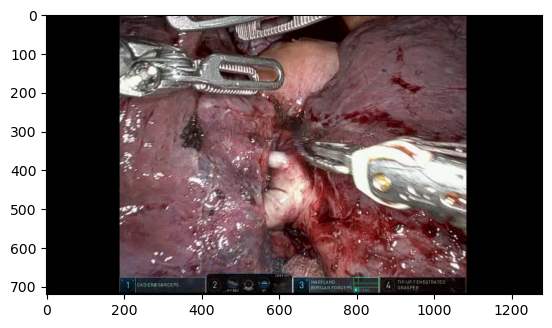

In [23]:
# plot a sample image
img = io.imread("../Patient01_AnnotationComplete/extracted_frames/frame_000000.png")
plt.imshow(img); plt.show()

190 0 1084 711


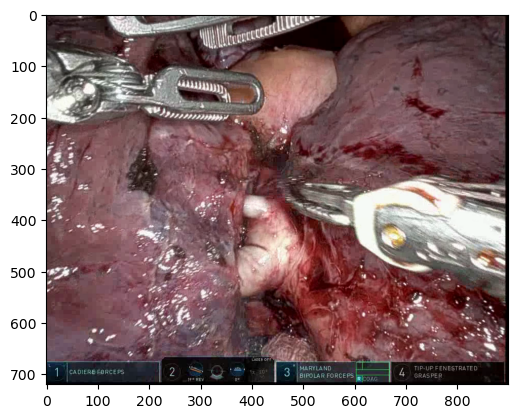

In [27]:
TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y = get_cropping_co_ord(img)
print(TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y) # 190 0 1084 711
# rouncding off the values
TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y = 190, 0, 1090, 720
img = img[TOPL_Y:BOTTOMR_Y, TOPL_X:BOTTOMR_X]
plt.imshow(img); plt.show()

In [39]:
for folder in Path("../").iterdir():
    if not "AnnotationComplete" in folder.name:
        continue
    json_path = search_json_files(folder)
    # sort the json paths based on the frame numbers in the json file name
    # extract number from folder name
    pat_name = 'p'+re.findall(r'\d+', folder.name)[0]
    print(f"Processing {pat_name}...")
    # create frames and mask folder
    os.makedirs(f"{folder}/frames", exist_ok=True)
    os.makedirs(f"{folder}/masks", exist_ok=True)

    for path in json_path:

        frame_numbers = extract_frame_numbers(path)
        frame_set = set()
        for frame_range in frame_numbers:
            # Set of all numbers in the JSON path
            # Eg: Patient1_ ... rll-frames1401-1650_1900-2400/instances_default.json
            # frame_set = {1401, 1402, ..., 1649, 1650, 1900, 1901, ..., 2399, 2400}
            start,end = frame_range
            frame_set.update(range(start,end+1))
        print(f"Total frames in {path.parent.name} = {len(frame_set)}")

        # read the json file
        with open(path, 'r') as f:
            json_data = json.load(f)
        # image_id to frame_num eg: 1:int('000000') -> 1:0 
        id2name = {img_data["id"]:int(re.findall(r'\d+', img_data["file_name"])[0]) for img_data in json_data["images"]}
        name2id = {v:k for k,v in id2name.items()}
        
        flag = True
        for ann in tqdm(json_data["annotations"]):
            # Annotations is present, but maybe it was for test, not included in file name
            if id2name[ann["image_id"]] not in frame_set:
                continue

            if flag: # First Frame
                prev_img_id = ann["image_id"]
                segmentations = []
                flag = False

            if ann["image_id"] != prev_img_id:
                # get the frame number
                frame_num = id2name[prev_img_id]
                # get the image
                img = io.imread(f"{folder}/extracted_frames/frame_{frame_num:06d}.png")
                # crop the image
                img = img[TOPL_Y:BOTTOMR_Y, TOPL_X:BOTTOMR_X]
                # save the image
                io.imsave(f"../frames/{pat_name}/frame_{frame_num:06d}.png", img)
                # if there are segmentations present
                if len(segmentations) > 0:
                    # Convert polygon points to Mask
                    mask = np.zeros(img.shape[:2], dtype=np.uint8)
                    mask = cv2.fillPoly(mask, segmentations, 1) # Binary Mask with class value 1
                    # Save mask to the patient masks folder
                    io.imsave(f"../masks/{pat_name}/frame_{frame_num:06d}.png", mask, check_contrast=False)

                # reset
                prev_img_id = ann["image_id"]
                segmentations = []

            # get the segmentation
            polygon = np.array(ann["segmentation"]).reshape((-1, 2)).astype(np.int32)
            # Adjust polygon coordinates based on the crop
            polygon[:, 0] -= TOPL_X
            polygon[:, 1] -= TOPL_Y
            segmentations.append(polygon)

Processing p03...
Total frames in ../Patient03_AnnotationComplete/lul - arterial dissection pt 3 - annotations-frames790-1090/instances_default.json = 301


  0%|          | 0/1281 [00:00<?, ?it/s]

100%|██████████| 1281/1281 [01:39<00:00, 12.86it/s]


Processing p02...
Total frames in ../Patient02_AnnotationComplete/lul-arterial-dissection-pt2-frames1750-1900/instances_default.json = 151


100%|██████████| 452/452 [00:47<00:00,  9.62it/s]


Total frames in ../Patient02_AnnotationComplete/lul-arterial-dissection-pt2-frames1600-1749/instances_default.json = 150


100%|██████████| 453/453 [00:46<00:00,  9.85it/s]


Processing p01...
Total frames in ../Patient01_AnnotationComplete/lul-arterial-dissection-pt1-frames0000-1000/instances_default.json = 1001


100%|██████████| 5238/5238 [04:34<00:00, 19.09it/s]


# Test

(720, 900, 3)


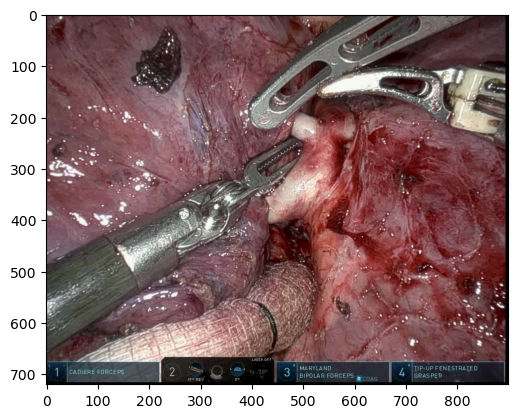

(720, 900, 3)


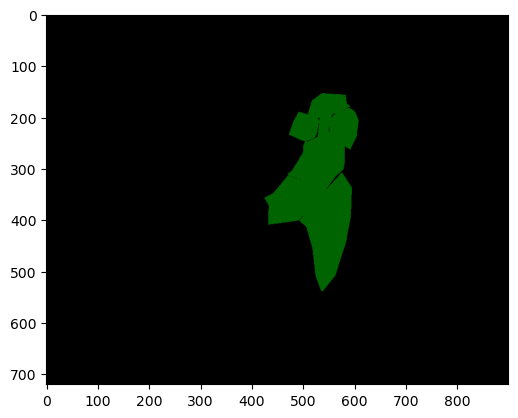

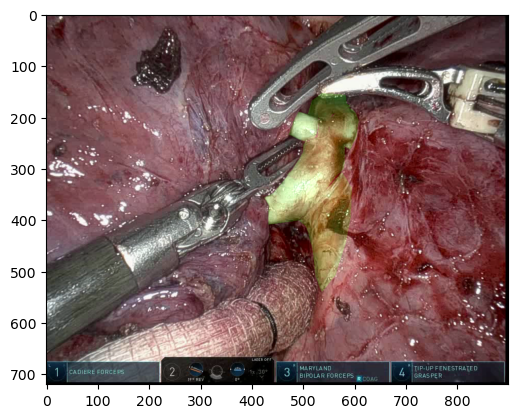

In [40]:
frame = io.imread("../Patient01_AnnotationComplete/frames/frame_000800.png")
mask = io.imread("../Patient01_AnnotationComplete/masks/frame_000800.png")
print(frame.shape)
plt.imshow(frame); plt.show()
mask = np.tile(mask[..., np.newaxis], (1,1,3))
mask = np.where(mask != 0, (0,100,0), 0).astype(np.uint8)
print(mask.shape)
plt.imshow(mask); plt.show()
# Overlayed image
plt.imshow(cv2.addWeighted(frame, 1, mask, 0.5, 0)); plt.show()